<a href="https://colab.research.google.com/github/2SUBDA/Breakouts/blob/Week7/APriestlyLookatMadness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Based on Ryan Barnes interesting take on March Madness
# Data available from Kaggle March Machine Learning - 2017

In [3]:
# Base Packages

import pandas as pd
import pymc3 as pm 
# This is the new package - more details here - https://docs.pymc.io/ 
# Allows us to build a monte carlo model

import numpy as np
import theano.tensor as tt 
# This is also a new package - more details here - http://deeplearning.net/software/theano/tutorial/
# Additional deep dive with pymc available here - https://docs.pymc.io/PyMC3_and_Theano.html
# Theano uses python to build models symbolically
# Allows GPU code generation

import matplotlib.pyplot as plt

# This is the initialization method - see https://docs.pymc.io/en/v3/api/inference.html for more details
init='adapt_diag'

In [ ]:
# OBTAIN

df = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/Breakouts/Week7/RegularSeasonCompactResults.csv')


In [ ]:
# SCRUB - Remove prior season records - for simplicity

df=df[df['Season']==2016]
df.head()
#len(df)

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
139920,2016,11,1104,77,1244,64,H,0
139921,2016,11,1105,68,1408,67,A,1
139922,2016,11,1112,79,1334,61,H,0
139923,2016,11,1115,58,1370,56,A,0
139924,2016,11,1116,86,1380,68,H,0


In [ ]:
# SCRUB - Convert to four df - 
df['Home Score'] = [obj2 if obj1 == 'H' or obj1 == 'N' else obj3 for obj1,obj2,obj3 in zip(df['Wloc'],df['Wscore'],df['Lscore'])]
df['Away Score'] = [obj3 if obj1 != 'H' or obj1 != 'N' else obj2 for obj1,obj2,obj3 in zip(df['Wloc'],df['Wscore'],df['Lscore'])]
df['Home Team'] = [obj2 if obj1 == 'H' or obj1 == 'N' else obj3 for obj1,obj2,obj3 in zip(df['Wloc'],df['Wteam'],df['Lteam'])]
df['Away Team'] = [obj3 if obj1 != 'H' or obj1 != 'N' else obj2 for obj1,obj2,obj3 in zip(df['Wloc'],df['Wteam'],df['Lteam'])]

In [ ]:
# SCRUB - Recode team numbers

teams = df['Home Team'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='Home Team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='Away Team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [ ]:
# SCRUB - Find specific team
# Using Teams index numbers from Kaggle

teams.loc[teams['team'] == 1393]

,team,i
88,1393,88


In [ ]:
# SCRUB - Rename scores

observed_home_points = df['Home Score'].values
observed_away_points = df['Away Score'].values

advantage = np.array([1 if obj=='H' or obj=='A' else 0 for obj in df['Wloc']],dtype='int64')

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

In [ ]:
# MODEL - Build bayesian model
# Latent variables - offs_star / defs_star 
# Latent variables - scoring intensity

model = pm.Model()
with pm.Model() as model:
    # global model parameters - the basics for below - intercept / std dev / home effect
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters - offensive & defensive strength
    offs_star = pm.Normal("offs_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)
    # second strength parameter centered on average
    offs = pm.Deterministic('offs', offs_star - tt.mean(offs_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    # derive the scoring intensity for a game - Home Court Advantage
    home_theta = tt.exp(intercept + home*advantage + offs[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + offs[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_points)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_points)

In [ ]:
!pip install causalgraphicalmodels

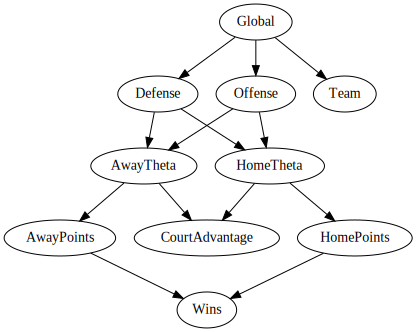

In [ ]:
# MODEL - Visualize the model

from causalgraphicalmodels import CausalGraphicalModel

madness = CausalGraphicalModel(
    nodes=["Global", "Team", "Offense", "Defense", "CourtAdvantage", "HomeTheta", 
           "AwayTheta", "HomePoints", "AwayPoints", "Wins"],
    edges=[
        ("Global", "Team"), 
        ("Global", "Offense"), 
        ("Global", "Defense"),
        ("Offense", "HomeTheta"),
        ("Offense", "AwayTheta"),
        ("Defense", "HomeTheta"),
        ("Defense", "AwayTheta"),
        ("HomeTheta", "CourtAdvantage"), 
        ("AwayTheta", "CourtAdvantage"), 
        ("AwayTheta", "AwayPoints"),
        ("HomeTheta", "HomePoints"),
        ("HomePoints", "Wins"),
        ("AwayPoints", "Wins")
    ]
)

# Draw the model

madness.draw()

In [ ]:
with model:
    #trace = pm.sample(1000, tune=1000, cores=2)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, offs_star, intercept, sd_def, sd_att, home]
Sampling 2 chains: 100%|██████████| 4000/4000 [02:44<00:00, 24.38draws/s]


FYI:  Compare results between runtimes:

*   CPU Time - 498 secs
*   GPU Time - 512 secs?

Why no change? 

1.   Check runtime environment
2.   Try the commented out line for running multiple jobs - might see slight improvement



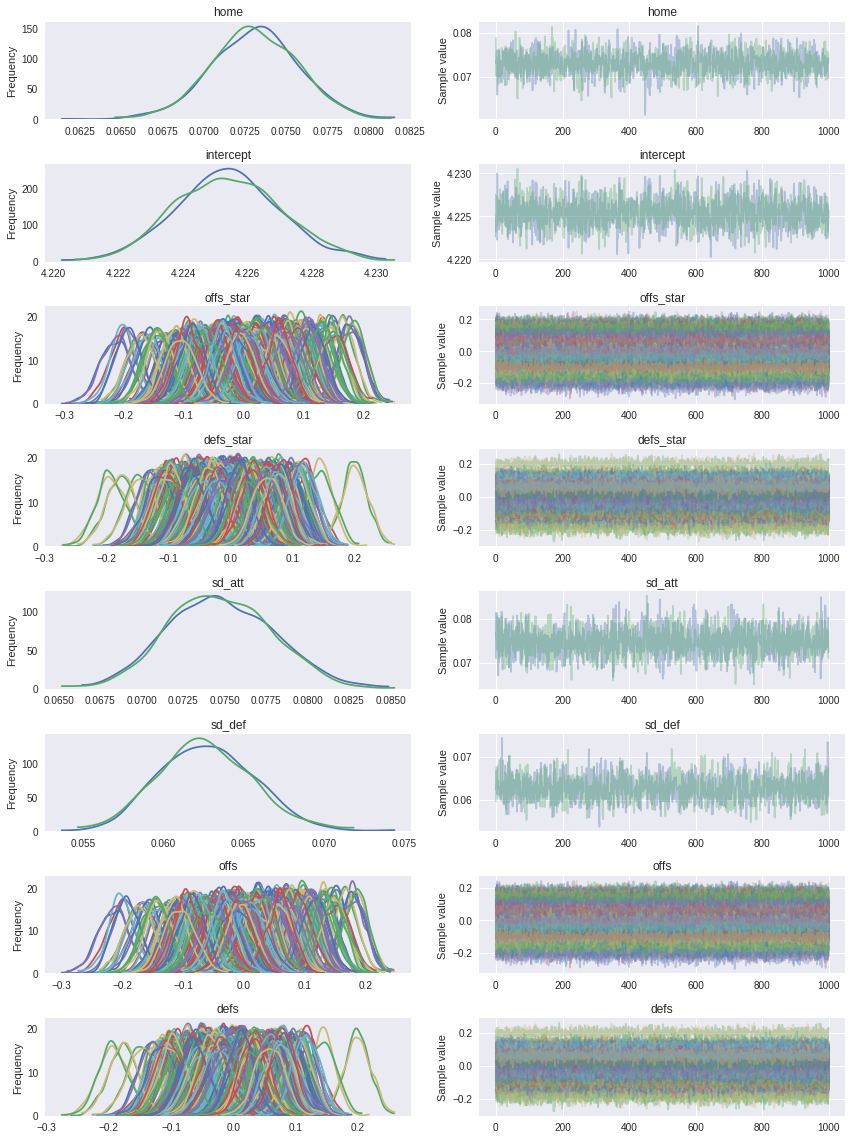

In [ ]:
# Interpret - Show results

pm.traceplot(trace)
plt.show()

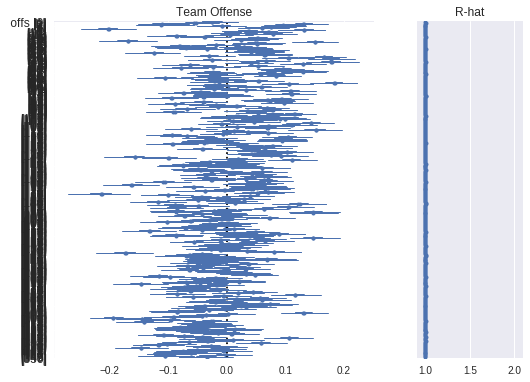

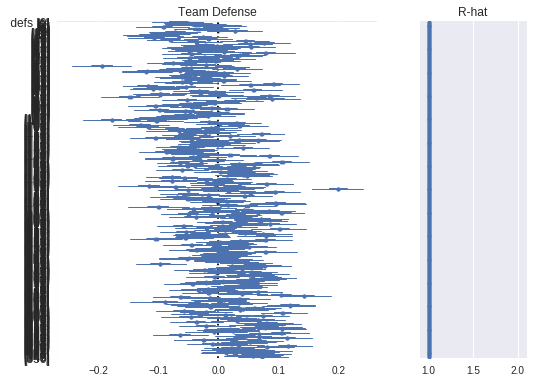

In [ ]:
# Interpret - Look for stronger teams on offense or defense

pm.forestplot(trace, varnames=['offs'], main="Team Offense")
plt.show()
pm.forestplot(trace, varnames=['defs'], main="Team Defense")
plt.show()

In [ ]:
# RECOMMEND - Build game simulator
tmA = 300
tmS = 88

teamA_home_wins_=[]
teamB_home_wins_=[]
neutral_A_wins_=[]
for i in range(1000):
    draw=np.random.randint(0,1000)
    home_=trace['home'][draw]
    intercept_=trace['intercept'][draw]
    offs_=trace['offs'][draw]
    defs_=trace['defs'][draw]
    home_theta_=np.exp(intercept_+home_+offs_[tmA]+defs_[tmS])
    away_theta_=np.exp(intercept_+offs_[tmS]+defs_[tmA])
    home_scores_=np.random.poisson(home_theta_,1)
    away_scores_=np.random.poisson(away_theta_,1)
    
    teamA_home_wins=[1 if obj>0 else 0 for obj in home_scores_-away_scores_]
    teamA_home_wins_.append(np.mean(teamA_home_wins))
    
    home_theta_=np.exp(intercept_+home_+offs_[tmS]+defs_[tmA])
    away_theta_=np.exp(intercept_+offs_[tmA]+defs_[tmS])
    home_scores_=np.random.poisson(home_theta_,1)
    away_scores_=np.random.poisson(away_theta_,1)
    
    teamB_home_wins=[1 if obj>0 else 0 for obj in home_scores_-away_scores_]
    teamB_home_wins_.append(np.mean(teamB_home_wins))
    
    home_theta_=np.exp(intercept_+offs_[tmA]+defs_[tmS])
    away_theta_=np.exp(intercept_+offs_[tmS]+defs_[tmA])
    home_scores_=np.random.poisson(home_theta_,1)
    away_scores_=np.random.poisson(away_theta_,1)
    
    neutral_A_wins=[1 if obj>0 else 0 for obj in home_scores_-away_scores_]
    neutral_A_wins_.append(np.mean(neutral_A_wins))
    
   

In [ ]:
# RECOMMEND - Results
    
print('Probability Army beats Syracuse at USMA: {0}%'.format(100*np.mean(teamA_home_wins_)))
print('Probability Army beats Syracuse at Dome: {0}%'.format(100-100*np.mean(teamB_home_wins_)))
print('Probability Army beats Syracuse at Neutral Site: {0}%'.format(100*np.mean(neutral_A_wins_)))

Probability Army beats Syracuse at USMA: 28.199999999999996%
Probability Army beats Syracuse at Dome: 10.099999999999994%
Probability Army beats Syracuse at Neutral Site: 16.8%
